# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

C:\Users\vkaynig\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [2]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

# Solution Written by Louie Hoang

**ANSWER (best viewed in a non-Chrome browser e.g. Internet Explorer, Edge, etc...):**
$\newcommand\given[1][]{\:#1\vert\:}$

Let the number of survey answers received for company $i$ be $n_i$ and the improvement answers be $\mathbf{y}_i \in \mathbb{R}^{n_i}$. Then under our problem setup, each $y_{i,j}$ is a normal random variable drawn i.i.d for each $i$ from: $y_{i,j} \sim \mathcal{N}(s_i \given[\Big] \mu_i, \sigma^2)$, where $\mu_i, \sigma$ are the mean and standard deviations of the distribution. Note that $\sigma$ is constant for each company due to our assumption that all standard deviation observations come from a true underlying value. Let $\hat{\mu_i}, \hat{\sigma_i}$ be the observed mean and standard deviation of $\mathbf{y}_i$ ($\mathbf{y}_i$ are not observed), then:
$$\hat{\mu_i} = E(\mathbf{y}_i) = \frac{\sum_{j=1}^{n_i} y_{i,j}} {n_i}$$
$$\hat{\sigma}_i = std(\mathbf{y}_i)$$

Because we don't know how the mean parameters $\mu_i$ for each company are distributed, we would like to model & fit them to the observed data. The assumptions placed on $\mu_i$ by different type of poolings are:
1. Complete Pooling: There is one $\mu$ value for all companies and that our observed values $\hat{\mu}_i$ are different simply due to the effect of different sample sizes.
2. Unpooling: There is a different value $\mu_i$ for each company and that they are independent of each other. The observed values $\hat{\mu}_i$ are noisy versions of these.
3. Partial Pooling: There is a value $\mu_i$ for each company. However, unlike in (2), these are dependent on each other and are drawn from an underlying distribution: $\mu_i \sim P(\mu)$.

With **COMPLETE POOLING**, in addition to having a constant $\sigma$ for all $i$, the mean parameters are also constant and equal to $\mu$. Thus the sample means $\hat{\mu_i}$ also follow a normal distribution parameterized by: $\hat{\mu_i} \sim \mathcal{N}(\hat{\mu_i} \given[\Big] \mu, \sigma^2 / n_i) = \mathcal{N}(\hat{\mu_i} \given[\Big] \mu, \hat{\sigma}_i^2)$. Thus, the likelihood function is:
$$L(\hat{\mathbf{\mu}} \given[\Big] \mu, \{\hat{\sigma}_i\}) = \prod_{i} \mathcal{N}(\hat{\mu_i} \given[\Big] \mu, \hat{\sigma}_i^2) \Rightarrow LL = \log L(\hat{\mathbf{\mu}} \given[\Big] \mu, \{\hat{\sigma}_i\}) = \sum_{i} \log \mathcal{N}(\hat{\mu_i} \given[\Big] \mu, \hat{\sigma}_i^2) = C - \sum_{i} \frac{(\hat{\mu_i} - \mu)^2}{2 \hat{\sigma}_i^2} $$

To find $\mu$, we simply compute the MLE value:
$$
\frac{\partial LL}{\partial \mu} = \sum_{i} \frac{\hat{\mu_i} - \mu}{\hat{\sigma}_i^2} = 0 
\Rightarrow \sum_{i} \frac{\hat{\mu_i}}{\hat{\sigma}_i^2} = \mu \sum_{i} \frac{1}{\hat{\sigma}_i^2}
\Rightarrow \mu = \sum_{i} \frac{\hat{\mu_i}}{\hat{\sigma}_i^2} \Bigg/ \sum_{i} \frac{1}{\hat{\sigma}_i^2}
$$
Thus, the MLE estimate for $\mu$ is:

In [3]:
mu_cp = np.sum(data_means / (data_std * data_std)) / np.sum(1.0 / (data_std * data_std))
print 'Satisfaction Improvement under Complete Pooling is: {}'.format(mu_cp)

Satisfaction Improvement under Complete Pooling is: 8.95046875093


In addition, we could also approach this problem from a Bayesian perspective and form our prior beliefs about the value of $\mu$. Since we don't have too much information, we just assume that it's equally likely to be any point in the interval $[-100, 100]$. That is: $\mu \sim U(-100,100)$. Further, we note that the likelihood can also be expressed as a multivariate gaussian distribution $\mathbf{\hat{\mu}} \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$, where $\mathbf{\mu} \in \mathbb{R}^8 = [\mu, \mu, \ldots, \mu]; \mathbf{\Sigma} \in \mathbb{R}^{8 \times 8}: \Sigma_{i,i} = \hat{\sigma}_i^2$ and $\Sigma_{i,j} = 0$. Putting this in PyMC, we have:

 [-----------------100%-----------------] 10000 of 10000 complete in 0.4 sec

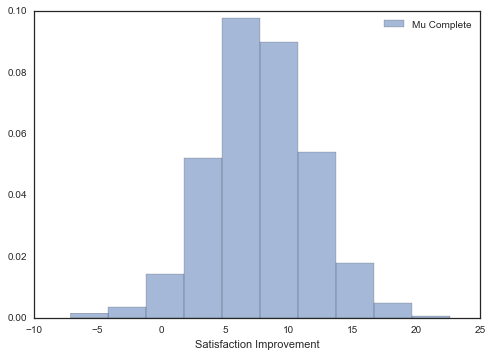

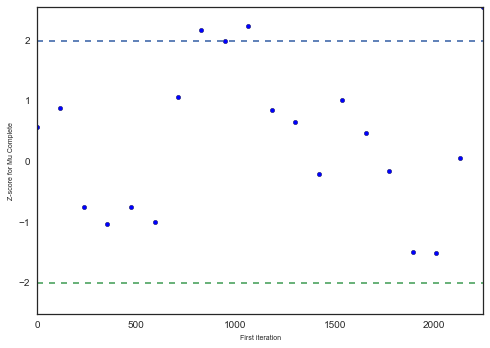

In [4]:
SigmaInv = np.zeros((8,8))
for i in range(8):
    SigmaInv[i,i] = 1.0 / (data_std[i] * data_std[i])
mu_complete = pm.Uniform('mu_u', lower=-100, upper=100)
likelihood_complete = pm.MvNormal("llc", mu = np.array([mu_complete]*8),
                                  tau = SigmaInv, value = data_means, observed = True)
mcmc = pm.MCMC([mu_complete, likelihood_complete])
mcmc.sample(iter=10000, burn=1000, thin=2)
mu_complete_trace = mu_complete.trace()
plt.hist(mu_complete_trace, alpha=0.5,align='left',normed=True,label='Mu Complete')
plt.xlabel('Satisfaction Improvement')
plt.legend(loc='upper right')
plt.show()
geweke_scores = pm.geweke(mu_complete_trace, first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "Mu Complete")

As we can see, our posterior seems to peak around the value which is close to the likelihood solution. The Geweke test does not seem to show any issues with non-convergence.

For **UNPOOLING**, since there is a different value $\mu_i$ for each $i$, the likelihood function is:
$$
L(\hat{\mathbf{\mu}} \given[\Big] \{\mu_i\}, \{\hat{\sigma}_i\}) = \prod_{i} \mathcal{N}(\hat{\mu_i} \given[\Big] \{\mu_i\}, \hat{\sigma}_i^2)
\Rightarrow LL = C - \sum_{i} \frac{(\hat{\mu_i} - \mu_i)^2}{2 \hat{\sigma}_i^2} \\
\Rightarrow \frac{\partial LL}{\partial \mu_i} = \frac{\hat{\mu_i} - \mu_i}{\hat{\sigma}_i^2} = 0 
\Rightarrow \mu_i = \hat{\mu_i}
$$

In [5]:
mu_up = data_means
print 'Satisfaction Improvement under Unpooling is'
print mu_up

Satisfaction Improvement under Unpooling is
[ 29.5   6.3  -3.9   7.2  -2.1   1.8  19.6  12. ]


Similarly as before, we can also apply additional priors to each value $\mu_i \sim U(-100, 100)$ and use PyMC: 

 [-----------------100%-----------------] 10000 of 10000 complete in 0.5 sec

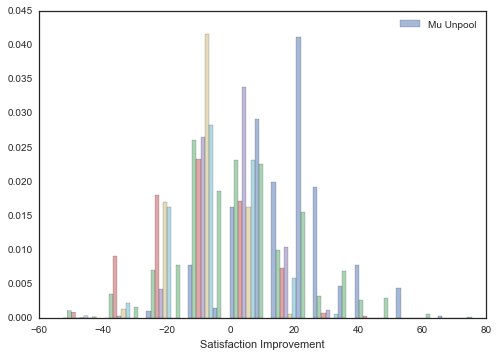

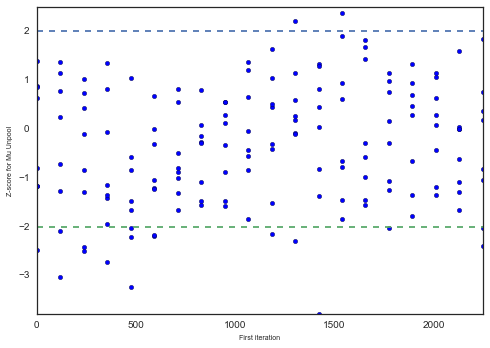

In [6]:
mu_un = pm.Uniform('mu_u', lower=np.ones(8)*(-100), upper=np.ones(8)*100)
likelihood_un = pm.MvNormal("llc", mu = mu_un, tau = SigmaInv,
                            value = data_means, observed = True)
mcmc = pm.MCMC([mu_un, likelihood_un])
mcmc.sample(iter=10000, burn=1000, thin=2)
mu_un_trace = mu_un.trace()
plt.hist(mu_un_trace, alpha=0.5,align='left',normed=True,label='Mu Unpool')
plt.xlabel('Satisfaction Improvement')
plt.legend(loc='upper right')
plt.show()
geweke_scores = pm.geweke(mu_un_trace, first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "Mu Unpool")


With **PARTIAL POOLING**, we assume there are different $\mu_i$ for each company $i$ drawn from the same distribution which we can specify via a prior. We will assume that they are normally distributed with mean $\mu_u$ and standard deviation $\sigma_u$. In addition, we'll also define uniform hyperpriors for these parameters. Our goal is to estimate them from the observed data. The formal setup is:

$$
\begin{align}
\mu_u &\sim U(-50,50) \\
\sigma_u &\sim U(10,40) \\
\mu_i &\sim \mathcal{N}(\mu_i \given[\Big] \mu_u, \sigma_u)
\end{align}
$$

 [-----------------100%-----------------] 100000 of 100000 complete in 38.9 sec

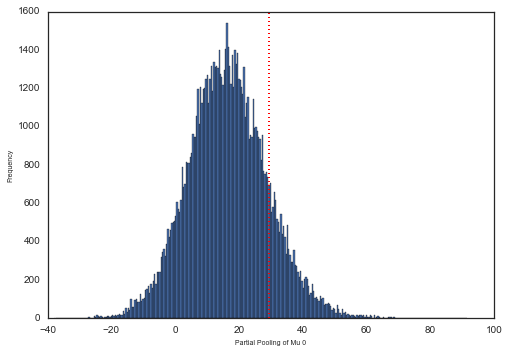

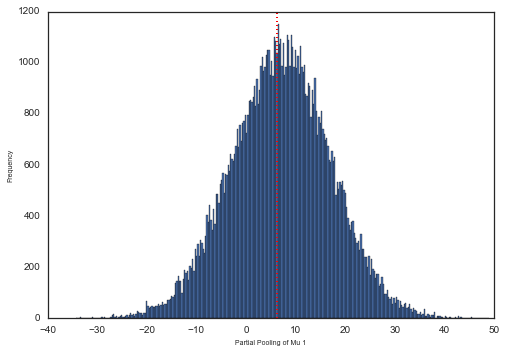

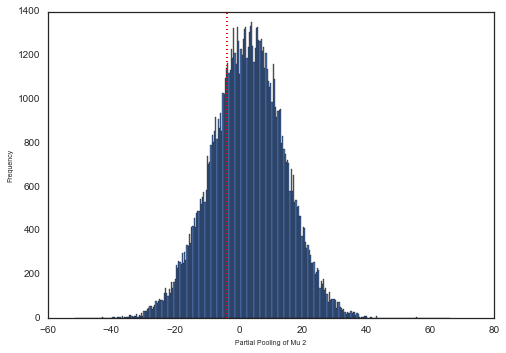

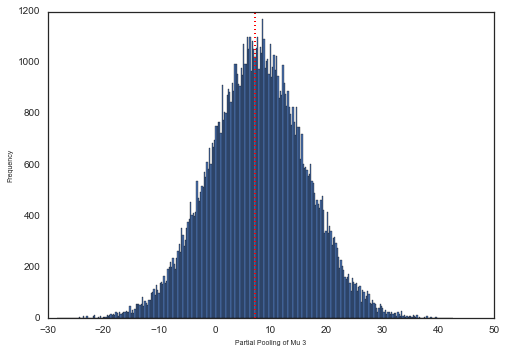

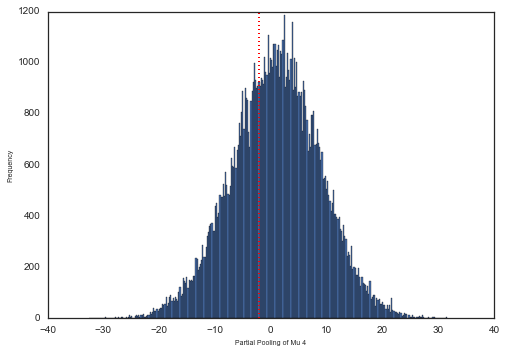

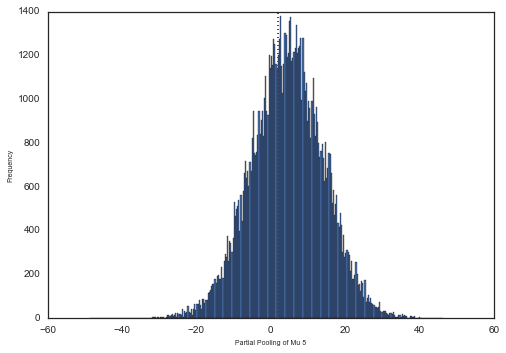

In [ ]:
mu_u = pm.Uniform('mu_u', lower=-50, upper=50)
sig_u = pm.Uniform('sig_u', lower=10, upper=40)

mu_i = pm.Container([pm.Normal("mu_i_%i" % i, mu=mu_u, tau=(1.0 / (sig_u * sig_u))) for i in range(8)])

likelihood_un = pm.Normal("llc", mu = mu_i, tau = 1 / (data_std ** 2),
                            value = data_means, observed = True)
mcmc = pm.MCMC([mu_u, sig_u, mu_i, likelihood_un])
mcmc.sample(iter=100000, burn=1000)

for i in range(8):
    pm.Matplot.gof_plot(mu_i[i], data_means[i], name='Partial Pooling of Mu %i' %i)

# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with the same length as $\mathbf{\hat{\theta_j}}$ and $\mathbf{b}$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.


# Solution Written by Rohan Thavarajah

In [2]:
f = open("HW3\\Sequences_new.dat", "r")
S = []
for i in f:
    S.append(i[:-1]) # scrap the line break character

## (a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

* I describe the equation by way of a stylized example. 
* Consider the following three sequences with two bases $b=\{A,B\}$ and 3-base long motifs (q=3).
* Let $S_1$ represent the current sequence and let $A_\hat{1}=(5,2)$. We wish to calculate $P(a_0=3 | A_\hat{1}, S)$.
* Then this set of alignments corresponds to the proposal of the following motifs where green shading is used for the current sequence and orange for the others. 

<img src="HW3_solution_data/HW3_problem2.png" width="500">

* The proposed motif in the current sequence is $[B,A,B]$. 

$$
\begin{align}
P(a_1=3 | A_\hat{1}, S) & = & & \text{P(B in the first position of the proposed motifs)/P(B in the background}) \\
& & \times & \quad \text{P(A in the second position of the proposed motifs)/P(A in the background}) \\ 
& & \times & \quad \text{P(B in the third position of the proposed motifs)/P(B in the background}) \\ 
\end{align}
$$

Consider the first position.
$$
\begin{align}
\text{P(B in the first position of the proposed motifs)} & = & \frac {\text{count}_{\text{B's in position 1 for orange cells}}} {\text{number of sequences - 1}} \\
& = & \frac{1}{2}
\end{align}
$$

and

$$
\begin{align}
\text{P(B in the background)} & = & \frac {\text{count}_{\text{B's in white cells}}} {\text{number of white cells}} \\
& = & \frac{8}{20}
\end{align}
$$


* Intuitively, the conditional probability of an alignment is correlated with the probability of observing each of the bases underlying the motif it proposes in the same position in the other sequences.
* The denominator weights bases that appear very frequently downward so that we better find a pattern and not just the most common bases.
* $\theta_j$, $\theta_0$ and $s_{i+j-1}$ are all vectors of length = $n_b$ (here =2). The exponent $s_{i+j-1}$ serves to select the vector elements associated with the base that is actually observed in the current sequence at the pertinent position.

## (b) Construct thetas

**In accordance with Taylor's note on Piazza I implement a pseudocount = 0.1**

In [3]:
A_initial = np.random.randint(0,196,size=20) # vector of alignments for start position of proposed motif
b = ['M','0','2','A','7'] # all bases
pseudocount = 0.1 # see note about piazza
n_b = len(b) # number of bases
q = 5 # length of motif
len_S = 200 # length of a sequence
n_S = 20 # number of sequences
'''
TAKES
S = list of sequences
S_exclude = sequence to exclude
A = vector of start positions for the motifs
RETURNS
theta_js = the probability of observing the q bases at the corresponding position of the current sequence
theta_0 = and the probabilities of finding the same bases in the background.
'''
def get_thetas(S, S_exclude, A):

    theta_js = np.zeros((n_b,q)) # rows = bases, columns = positions in motif
    for pos_in_motif in np.arange(0,q):
        bases_at_pos = [S[i][A[i]+pos_in_motif] for i in np.arange(0,n_S) if i!=S_exclude] 
        theta_j_counts = np.array([bases_at_pos.count(base) + pseudocount for base in b]) 
        theta_j = theta_j_counts.astype(float) / np.sum(theta_j_counts)
        theta_js[:,pos_in_motif] = theta_j
    
    background = ''
    for seq_ind in np.arange(0,n_S):
        if seq_ind!=S_exclude:
            background = background + S[seq_ind][:A[seq_ind]] + S[seq_ind][A[seq_ind]+q:]
    theta_0_counts = np.array([background.count(base) + pseudocount for base in b]) 
    theta_0 = theta_0_counts.astype(float) / np.sum(theta_0_counts) 
    
    return theta_js, theta_0

theta_js, theta_0 = get_thetas(S, 0, A_initial)

## (c) derive the conditional probability over all possible alignments for your current sequence and draw a sample from it.

In [4]:
'''
TAKES
S = list of sequences
S_exclude = sequence to exclude
A = vector of start positions for the motifs
RETURNS
cond_prob = the UNNORMED conditional probability
'''
def cond_prob(S, S_exclude, A):
    theta_js, theta_0 = get_thetas(S, S_exclude, A)

    ratios = np.zeros( (n_b,q) ) # rows = bases, columns = positions in motif
    for pos in np.arange(0,q):
        ratios[:,pos] = theta_js[:,pos] / theta_0
        
    motif = S[S_exclude][A[S_exclude]:][:q]
    motif_indexes = [b.index(base) for base in motif]

    cond_prob = 1.
    for pos in np.arange(0,q):
        cond_prob = cond_prob * ratios[motif_indexes[pos], pos]
    return cond_prob

cond_prob(S, 0, A_initial)

1.8626206024746028

## I test two different sampling techniques

**(i) Sample using lookup table and inverse transform**

In [5]:
'''
TAKES
S = list of sequences
S_exclude = sequence to exclude
A = vector of start positions for the motifs

PURPOSE
draw a sample from the conditional probability distribution
sampling is via construction of a lookup table and inverse transform

RETURNS
A_new = Updated alignment for the sequence S_exclude (all others remain the same)
'''

def draw_ak(S, S_exclude, A):
    # construct lookup table
    cond_prob_lkup = np.zeros(len_S-q)
    A_tmp = A.copy()
    for a in np.arange(0,len_S-q):
        A_tmp[S_exclude] = a
        cond_prob_lkup[a] = cond_prob(S, S_exclude, A_tmp)
    cond_prob_cumsum = cond_prob_lkup.cumsum()    
    cond_prob_cumsum_normed = cond_prob_cumsum / cond_prob_cumsum[len_S-q-1]   
    
    # get a_new
    threshold = np.random.rand()
    a_new = 0
    for cum_p in cond_prob_cumsum_normed:
        if (cum_p<threshold):
            a_new = a_new + 1
    
    A_new = A.copy()
    A_new[S_exclude] = a_new
    
    return A_new

print A_initial 
print cond_prob(S, 1, A_initial)
test = draw_ak(S, 1, A_initial)
print test
print cond_prob(S, 1, test)

[ 81  17  78  78 177 174  85 149 183 132 154  74 165 146 191   5 111  84
  11   9]
0.911519131422
[ 81 138  78  78 177 174  85 149 183 132 154  74 165 146 191   5 111  84
  11   9]
3.09692322808


**(ii) Sample using Metropholis-Hastings**

In [6]:
'''
TAKES
S = list of sequences
S_exclude = sequence to exclude
A = vector of start positions for the motifs

PURPOSE
draw a sample from the conditional probability distribution
sampling is via metropolis hastings

RETURNS
A_new = Updated alignment for the sequence S_exclude (all others remain the same)
'''

def draw_ak_mh(S, S_exclude, A):
    # propose
    A_prop = A.copy()
    A_prop[S_exclude] = np.random.randint(0,len_S-q+1)    
    
    # compute probabilities
    prob_new = cond_prob(S, S_exclude, A_prop)
    prob_old = cond_prob(S, S_exclude, A)
    acceptance_prob = prob_new / prob_old
    
    # coin toss
    if np.random.uniform() < acceptance_prob:
        return A_prop
    else:
        return A

print A_initial 
print cond_prob(S, 1, A_initial)
test = draw_ak(S, 1, A_initial)
print test
print cond_prob(S, 1, test)


[ 81  17  78  78 177 174  85 149 183 132 154  74 165 146 191   5 111  84
  11   9]
0.911519131422
[ 81 174  78  78 177 174  85 149 183 132 154  74 165 146 191   5 111  84
  11   9]
0.350093769444


**Discussion on my choice of step size for metropolis hastings.**
* Because I expect the conditional probability of any alignment more than 5 base units away from the current alignment and the conditional probability of the current alignment to be unrelated I choose a step size that spans the entire sequence. 

## (d) Iterate over all p sequences. [...] After enough Gibbs iterations you should start noticing that the algorithm has converged.

**(i) FIND MOTIF USING INVERSE TRANSFORM SAMPLING**

In [7]:
%%time
A_initial = np.random.randint(0,len_S-q+1,size=20)
A = A_initial

sum_cond_probs_old = 0
for i in np.arange(0,1000):
    for seq_ind in np.arange(0,n_S):
        A = draw_ak(S, seq_ind, A)
    if i%50==0:
        sum_cond_probs = np.sum([cond_prob(S, seq_ind, A) for seq_ind in np.arange(0,n_S)])
        print A
        print sum_cond_probs
        if (sum_cond_probs==sum_cond_probs_old):
            break
        else:
            sum_cond_probs_old = sum_cond_probs

[ 13  73 106  95 115 125  29 161  25  88 184  95 170  23 110 146 170 145
  32  36]
193.015575203
[ 63 151  68 154  27  58  27  98  71 155  22 125  62   5 186 125  85 145
 143  58]
14537.6381705
[ 63 151  68 154  27  58  52  98  71 155  22 125  62  86  64 125  85 145
  45  89]
14336.9707708
[ 63 151  68 154  27  58  27  98  71 155 145 125  62   5 132 125 175 145
  45  58]
13059.3566363
[165 151  68 154  27  58  27  98  71 155 145 125  62  86 166 125 175 145
 153 112]
9363.33035182
[ 63  11  68 154  27  58  75  29  71 155 145 125  62  86 155 125  85 145
  45 171]
10338.1752262
[ 63 151  68 154  27  58  52  98  71 155  22 125  62   5 132 125  85 145
  45 171]
15787.4546817
[ 63 151  68 154  27  58  52  98  71 155  22 125  62  86  24 125  85 145
  45 171]
13803.8950272
[ 63 151  68 154  27  58  27  98  71 155 145 125  62   5  64 125  85  90
 153  58]
12153.2485571
[ 63 151  68 154  27  58  52  98  71 155 145 125  62   5 166 125  85 145
  45  89]
14511.7795475
[ 63 151  68 154  27  58  52  

**(ii) FIND MOTIF USING METROPOLIS HASTINGS SAMPLING**

In [8]:
%%time
A_initial = np.random.randint(0,len_S-q+1,size=20)
A = A_initial

sum_cond_probs_old = 0
for i in np.arange(0,70000):
    for seq_ind in np.arange(0,n_S):
        A = draw_ak_mh(S, seq_ind, A)
    if i%5000==0:
        sum_cond_probs = np.sum([cond_prob(S, seq_ind, A) for seq_ind in np.arange(0,n_S)])
        print A
        print sum_cond_probs
        if (sum_cond_probs==sum_cond_probs_old):
            break
        else:
            sum_cond_probs_old = sum_cond_probs

[ 93  59  58  54 151 135  76 150 192  35 144  89 127 168 113 147  69  90
 171 120]
28.3800091063
[ 32  23 122 145  54 163  17 137 175 162  43  69   8  96   0 188  54 105
 107 134]
4090.97036996
[166 140   5 145  54 166 187 137 117 162  25 100 153 149  25 134 176   8
 126 134]
3431.92406677
[ 64 152  10  96  28  59 149  30 166 123   2 126  69   6 156  56  86 146
 179 172]
8343.4609465
[ 64 152  10  96  28  59   9  99 166 123 146 126  69   6   3  56  86 146
 179 172]
6117.48746383
[ 93 152  10 155  28  59   2  30 166 123  23 126  69  87 156  56  86 146
 110 172]
6431.20627279
[ 64 152  10  96  98  59 149  30 166   4 112 126  69  87 133  56  86 146
 179 172]
7115.15381837
[ 64 152  10  96  28  59 149  30 166 123   9 126  69   6 156  56  86 146
 179 172]
8150.67890267
[ 64 152  81  21  28  59 149 160  35 156   9 189  69   6 156  56  86 146
 179 172]
4172.24036824
[ 64 152  10  96  28  59  76  30 166 123 146 126  69  87 133   4  86 146
 179 172]
7726.39760695
[ 64 195  10  96  28  95  28  3

## An extension - adding a 1-step translation to ALL alignments every 5000 iterations

* Although both of the examples above converged to the right alignments, I noticed that there was a tendency to get stuck oscillating around alignments where the majority were positioned at the true alignments plus or minus 1 position.
* This showcases a possible weakness of a Gibb's approach for this problem. Suppose we initialize with the alignment = true alignment plus 1 character (e.g. M207x). We would like to move all the alignments at once so that we have AM207. But if we move only one sequnce at a time, AM207 has a poor match with M207x. 
* I propose every x iterations, testing if we improve the sum of conditional probabilities if we perform a 1 unit translation of ALL the alignments at once.
* Indeed I found this approach converged to the true positions much more consistently.

In [9]:
'''
TAKES
A = current alignments 
x = units to translate
RETURNS
A_new = the current alignments plus x units (without stepping outside the bounds of the sequences)
'''

def translate_A_x_units(A, x):
    A_new = []
    for ak in A:
        ak_new = ak + x
        if ak_new<0:
            ak_new=0
        elif ak_new>len_S-q:
            ak_new=len_S-q
        A_new.append(ak_new)
    return np.array(A_new)
    

In [10]:
%%time
A_initial = np.random.randint(0,len_S-q+1,size=20)
A = A_initial

sum_cond_probs_old = 0
for i in np.arange(0,70000):
    for seq_ind in np.arange(0,n_S):
        A = draw_ak_mh(S, seq_ind, A)
    if i%5000==0:
        sum_cond_probs = np.sum([cond_prob(S, seq_ind, A) for seq_ind in np.arange(0,n_S)])
        print A
        print sum_cond_probs
        if (sum_cond_probs==sum_cond_probs_old):
            break
        else:
            sum_cond_probs_old = sum_cond_probs
            
        # escape local maxima
        # if we can find do better by translating start positions by one unit do so
        A_plus1 = translate_A_x_units(A, 1)
        A_plus1_sum_probs = np.sum([cond_prob(S, seq_ind, A_plus1) for seq_ind in np.arange(0,n_S)])
        A_minus1 = translate_A_x_units(A, -1)
        A_minus1_sum_probs = np.sum([cond_prob(S, seq_ind, A_minus1) for seq_ind in np.arange(0,n_S)])
        
        if (A_plus1_sum_probs>sum_cond_probs) and (A_plus1_sum_probs>A_minus1_sum_probs):
            A = A_plus1
        elif (A_minus1_sum_probs>sum_cond_probs) and (A_minus1_sum_probs>A_plus1_sum_probs):
            A = A_minus1

[189  43 173  14  90 135 111   8  98 122  59 146 147   6 125  17  52  73
 132 179]
37.4016055124
[ 93 152  10 155  28 166 125  30 166 123   2 126  69   6 156 126  86 146
 179 176]
5455.06221547
[ 64 152  10  96  28  59 117  30 166 123   2 126  69   6 133  56  86  25
 110 185]
4914.4893135
[ 64 152  10 155  28  52   2  30 104 189 151 126  69  87 156 126  86 146
 179 172]
6710.97462318
[ 64 152  69  96  28  59 149  99  35  55 112 126  69   6   3  56  86 146
 150 172]
5556.13385246
[ 63  11  68 154  27  58  52  98  71 155  22 125  62   5 186 125  85 145
  45  89]
15297.079622
[ 62 150  30 153  26  57  51  97  70 154  37 124  61  85 165 124  84 144
  44  88]
56521.2804371
[ 62 150  30 153  26  57  51  97  70 154  37 124  61  85 165 124  84 144
  44  88]
56521.2804371
Wall time: 5min 2s


# All sampling techniques converge on the same final alignment. What is the motif?

In [11]:
A_final = A
motif_list = [S[ind][a:][:q] for ind, a in enumerate(A_final)]
print "final motif start positions:"
print A_final
print "motifs at final positions:"
print motif_list

final motif start positions:
[ 62 150  30 153  26  57  51  97  70 154  37 124  61  85 165 124  84 144
  44  88]
motifs at final positions:
['AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207', 'AM207']


# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [3]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])

# Solution Written by 

Plan:
- define energy function = negative total value of our luggage (negative because we are maximizing) 
- save current solution as an array of indices of chosen luggage
- make a function that makes the next proposal (will be discusse more)
- make a function that returns the weight of current suggestion
- SA function:
    - propose new solution with one of the algorithms
    - caluclate its energy
    - if new energy is smaller, accept
    - if it's larger, toss the coin
    - count the iterations
    - check if it's time to cool down; thermostat
    - if too cold, reheat
    - if you're on the same spot for the last 100 iterations, reheat
    - set maximal number od iterations
    - set the reheating cycle
    - save current luggage values in an array, to be plotted later to analyze the convergence
- plot optimization path for different:
    - initial temperatures
    - cooling coefficients
    - suggestions strategy:
        - start with all luggage, and randomly drop items until we are at the weight limit [completely random]
        - start with all luggage, and randomly drop items until we are at the weight limit, but random function is weighted by the ratio V/W [biased random]
        - start with previous suggestion, drop one item randomly and add one, but can be under the weight limit

In [4]:
# helper functions

# returns the weight of current suggestion
def weight(indices):
    we = 0
    for ind in indices:
        we= we+ w[ind]
    return we
# energy function; actually its negative
def value(indices):
    va = 0
    for ind in indices:
        va= va+ v[ind]
    return va

In [5]:
# helper functions for second strategy for proposals

# returns a randomly chosen element from a list choices, weighted by v/w
# takes in a 2 by N matrix which has a weight v/w attached to each index i, where there are N i's
# code for weighted_choice copied from http://stackoverflow.com/questions/3679694/a-weighted-version-of-random-choice
def weighted_choice(choices):
   total = sum(w for c, w in choices)
   r = np.random.uniform(0, total)
   upto = 0
   for c, w in choices:
      if upto + w >= r:
         return c
      upto += w
   assert False, "Shouldn't get here"

# for a given array of indices, makes a 2 by N matrix which has a weight v/w attached to each index i, where there are N i's
def appendWeights(indices):
    s =[]
    for ind in indices:
        s.append([ind,v[ind]/float(w[ind])])
    return s

In [6]:
# next suggestion
# different ways to implement it

# first strategy: start with all luggage, and randomly drop items until we are at the weight limit [completely random]
def completelyRnd():
    # begin with all luggage
    sol = np.arange(len(w))
    curr_weight = weight(sol)
    while curr_weight>W:
        np.random.shuffle(sol)
        sol = sol[:(len(sol)-1)]

        #rnd = np.random.choice(sol)
        #sol = np.delete(sol,sol.index(rnd))
        curr_weight = weight(sol)
    return sol

# second strategy: start with all luggage, and randomly drop items until we are at the weight limit, 
# but random function is weighted by the ratio V/W [biased random]

def biasedRnd():
    # begin with all luggage
    sol = np.arange(len(w))
    curr_weight = weight(sol)
    while curr_weight>W:
        rnd = weighted_choice(appendWeights(sol))
        sol = np.delete(sol,sol.index(rnd))
        curr_weight = weight(sol)
    return sol

# third strategy:  drop one add one, can be under weight

def swapOne(previous):
    # drop random item and replace it with only one
    np.random.shuffle(previous)
    sol = previous[:(len(previous)-1)]
    curr_weight = weight(sol)
    
    while True:
        rnd = np.random.choice(np.arange(len(w)))
        if (not(rnd in sol))and((weight([rnd])+curr_weight)<W): 
            # if it's not taken, append it
            sol= np.append(sol,rnd)
            break
    return sol

# check the current solution and add items randomly until we reach the weight limit
def refillSol(previous):
    sol = previous
    curr_weight = weight(sol)
    # keep adding new items until we reach the weight limit
    while curr_weight<W:
        # choose a new item from all the items
        rnd = np.random.choice(np.arange(len(w)))
        # check if that item is not already taken
        if (not(rnd in sol)): 
            # if it's not taken, append it
            sol= np.append(sol,rnd)
        curr_weight = weight(sol)
    # if in the last loop we overshot the weight, pop out the last added item
    if curr_weight>W: 
        sol=sol[:len(sol)-1]
    return sol


In [7]:
# function for simulated annealing
# cool_coef: cooling coefficient
# initial_choice: initial choice for the luggage
# init_temp: initial temperature
# epoch: number of iterations between two cooling cycles
# max_iter: maximal number of iterations
# algCh: indicator for which proposal strategy to choose; takes values in [1,2,3,4]
def simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill):
        # save the current optima here
        optima = []
        optima.append(value(initial_choice))
        # save the best choice here
        best = initial_choice
        temp = init_temp
        current = initial_choice
        prevE = value(current)
        # count total iterations
        tot = 0
        while True:
            # choose the algorithm
            if algCh == 1:
                propose = completelyRnd()
            elif algCh == 2:
                propose = biasedRnd()
            elif algCh == 3:
                propose = swapOne(current)
            else: 
                print "Invalid input for AlgCh"
                break
            newE = value(propose)
            #print propose
            #print newE
            deltaE  =  -(newE -prevE) 
            
            if newE > prevE:
                # accept
                current  = propose
                optima.append(value(propose))
                prevE = newE  
                if value(propose)>value(best):
                    best = propose
            
            elif np.random.rand() < np.exp( -deltaE/float(temp)):
                # accept
                current  = propose
                optima.append(value(propose))
                prevE = newE  
                if value(propose)>value(best):
                    best = propose
            # count total iterations
            tot = tot+1
            
            # check if it is time to cool down
            if len(optima) % epoch == 0:
                temp = cool_coef * temp
            
            # if we get a lot under weight, refill the solution
            if len(optima) % refill == 0:
                current = refillSol(current)
            
            #if we get too cold, reheat
            if temp< 0.01:
                #temp = 1.5
                #used for long run
                temp = 2.0
            # print progress:
            if tot % 20000 ==0:
                print tot
            
            # check to stop:
            if tot> max_iter:
                break
        return best, optima

### Testing out choosing strategies 

1. Try out strategies 1 and 2, T=5, cool_ceof=0.9, start with a random choice

20000
40000
optimal choice for luggage:  [96 78 88 39 48 31 32 20 59 70 42 41 92 93]
the value of optimal choice:  537
the weight of optimal choice:  2905


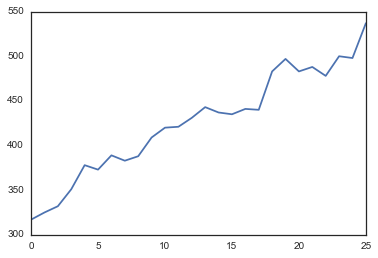

In [8]:
# simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill)
initial_choice =completelyRnd()

optimalValue, values = simulated_annealing(initial_choice, 5.0, 0.90,100,50000, 1,50)
print "optimal choice for luggage: ",optimalValue
print "the value of optimal choice: ",value(optimalValue)
print "the weight of optimal choice: ",weight(optimalValue)
plt.plot(values)

In [9]:
print len(values)

26


The problem with this and the strategy 2 implementations is that it doesn't use current optimal state efficiently since it suggests a new state every time; the acceptance rate is therefore extremely low (only 13/50000 !) since we are basically randomly searching for a solution. From now on, I will stick only to strategy 3, which looks at the history as well. Let's implement it now.

20000
40000
optimal choice for luggage:  [68 10  0 70 59 49 50 17 88 77 39 81 85 41 25 58 19 96]
the value of optimal choice:  786
the weight of optimal choice:  2997


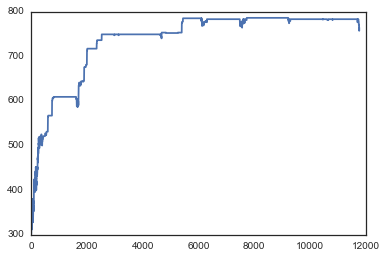

In [10]:
# simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill)
initial_choice =completelyRnd()
#strategy 3
optimalValue, values = simulated_annealing(initial_choice, 5.0, 0.90,100,50000, 3,50)
print "optimal choice for luggage: ",optimalValue
print "the value of optimal choice: ",value(optimalValue)
print "the weight of optimal choice: ",weight(optimalValue)
plt.plot(values)


Much better! The value is now 782, and the sequence converged. Weight is almost at the limit. Let's now play with temperature and cooling coefficient.

### Temperature and cooling coefficient

20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000


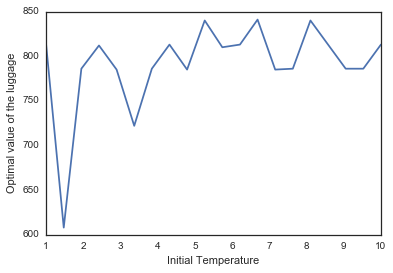

In [11]:
# simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill)
initial_choice =completelyRnd()
#strategy 3

# save the value for different starting temperatures
temps =np.linspace(1,10,20)
optimal_vals =[]
vals =[]
for temp in temps:
    optimalValue, values = simulated_annealing(initial_choice, temp, 0.90,100,50000, 3,50)
    optimal_vals.append(optimalValue)
    vals.append(values)
    
# plot optimal choice value vs temperature
finalVals = [value(opt) for opt in optimal_vals]

plt.plot(temps,finalVals)
plt.xlabel("Initial Temperature")
plt.ylabel("Optimal value of the luggage")
plt.show()

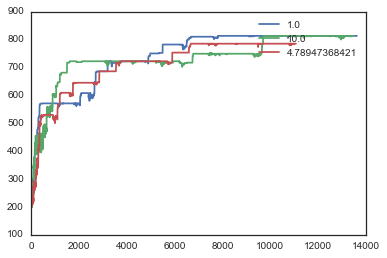

In [12]:
# plot low temp outcome

plt.plot(vals[0],label=temps[0])
#plot hight temp outcome
plt.plot(vals[19],label=temps[19])
plt.plot(vals[8],label=temps[8])
plt.legend()
plt.show()

We can see from the previous graph that low starting temperatures get us stuck at suboptimal values, similarly to higher ones (higher ones are still better though). Acceptance ratio is higher for higher temperatures (makes sense). It also looks like my initial temp=5 was the most optimal one. Let's now look at the cooling coefficients. 

20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000
20000
40000


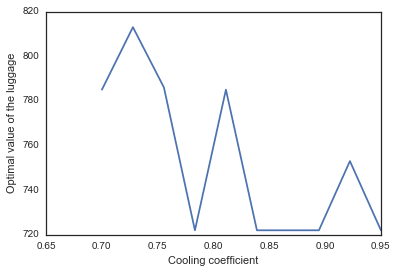

In [13]:
# simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill)
initial_choice =completelyRnd()
#strategy 3

# save the value for different starting temperatures
coefs =np.linspace(0.7,0.95,10)
optimal_vals2 =[]
vals2 =[]
for coef in coefs:
    optimalValue, values = simulated_annealing(initial_choice, 5, coef,100,40000, 3,50)
    optimal_vals2.append(optimalValue)
    vals2.append(values)
    
# plot optimal choice value vs temperature
finalVals2 = [value(opt) for opt in optimal_vals2]

plt.plot(coefs,finalVals2)
plt.xlabel("Cooling coefficient")
plt.ylabel("Optimal value of the luggage")
plt.show()

In [14]:
print coefs
print finalVals2

[ 0.7         0.72777778  0.75555556  0.78333333  0.81111111  0.83888889
  0.86666667  0.89444444  0.92222222  0.95      ]
[785, 813, 786, 722, 785, 722, 722, 722, 753, 722]


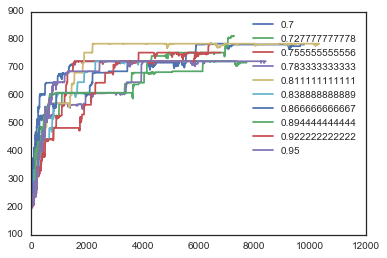

In [15]:
# plot outcomes

for i in range(10):
    plt.plot(vals2[i],label=coefs[i])
    plt.legend()
plt.show()

High cooling coefficient work worse than lower since we try to converge faster but instead get stuck in a local optimum. From this plot, vlaues of 0.72 or 0.86 work best, giving the max value of 813, which seemed to be the optimal value obtained by the variation of T as well. I will now stick to  T=5, c = 0.73, and compare it to greedy.

In [16]:
# greedy

indices = np.arange(len(w))
ar = appendWeights(indices)


val = []

for i in np.arange(len(w)):
    current = ar[i]
    tup = (current[0],current[1])
    val.append(tup)

dtype = [('index',int),('importance',float)]
final = np.array(val,dtype=dtype)
ssorted = np.sort(final, order='importance') 
#print ssorted

greedyValue =0
greedyWeight = 0
greedySeq =[]
for i in np.arange(len(w)):
    # go from behind
    current_i = len(w)-i-1
    index = ssorted[current_i][0]
    if (greedyWeight + weight([index]))<W:
        greedyWeight+= weight([index])
        greedyValue+=value([index])
        greedySeq.append(index)
    else:
        break
print greedyValue
print greedyWeight
print greedySeq

897
2806
[41, 77, 70, 88, 80, 0, 68, 58, 78, 3, 38, 10, 39, 92, 11, 49, 96, 18, 79, 50, 19, 85, 32]


20000
40000
optimal choice for luggage:  [58 39 76 19 85 68 41 59 88 49 50 77 10 81 25 70]
the value of optimal choice:  722
the weight of optimal choice:  2988


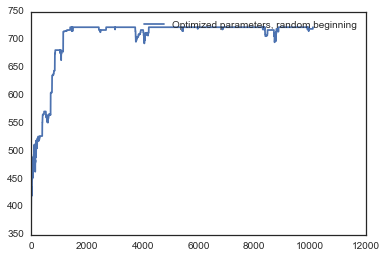

20000
40000
optimal choice for luggage:  [77 25 38 19 17 78 85  3  0 68 80 18 88 10 96 92 58 49 39 79 50 41 70]
the value of optimal choice:  916
the weight of optimal choice:  2995


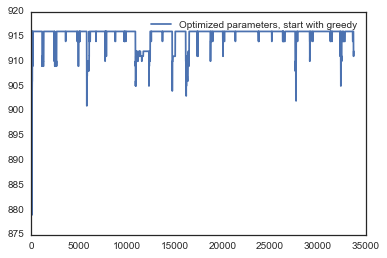

In [17]:
# simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill)
initial_choice =completelyRnd()
#strategy 3
optimalValue, values = simulated_annealing(initial_choice, 5, 0.73,100,50000, 3,50)
    
print "optimal choice for luggage: ",optimalValue
print "the value of optimal choice: ",value(optimalValue)
print "the weight of optimal choice: ",weight(optimalValue)
plt.plot(values,label=u"Optimized parameters, random beginning")
plt.legend()
plt.show()
# also try SA but with greedy solution as initial step!!
initial_choice = [41, 77, 70, 88, 80, 0, 68, 58, 78, 3, 38, 10, 39, 92, 11, 49, 96, 18, 79, 50, 19, 85, 32]
optimalValue, values = simulated_annealing(initial_choice, 5, 0.73,100,50000, 3,50)    
print "optimal choice for luggage: ",optimalValue
print "the value of optimal choice: ",value(optimalValue)
print "the weight of optimal choice: ",weight(optimalValue)
plt.plot(values,label=u"Optimized parameters, start with greedy")
plt.legend()
plt.show()

Starting with greedy is so far the best way!! Gives us the optimal value of 916, higher than just greedy (897). I will finally try out running SA with random beginning for a longer time to see if I can beat greedy. I will also change the intermediate heating temperature to 2.0 to allow for more movement. 

20000
40000
60000
80000
100000
optimal choice for luggage:  [49 39  0 19 96 58 80 85 77 81 25 18 10 59  3 68 41 88 50 70]
the value of optimal choice:  841
the weight of optimal choice:  2993


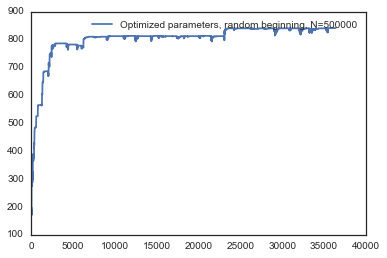

In [18]:
# simulated_annealing(initial_choice, init_temp, cool_coef,epoch,max_iter, algCh,refill)
initial_choice =completelyRnd()
#strategy 3
optimalValue, values = simulated_annealing(initial_choice, 5, 0.73,200,100000, 3,50)
    
print "optimal choice for luggage: ",optimalValue
print "the value of optimal choice: ",value(optimalValue)
print "the weight of optimal choice: ",weight(optimalValue)
plt.plot(values,label=u"Optimized parameters, random beginning, N=500000")
plt.legend()
plt.show()

The longer I run this, the better it gets, as expected. The best value-weight combination was still by starting with greedy and then optimizing (using the best of both worlds) :

optimal choice for luggage:  [25 88 39 85 78 79  3 58 10 50 49 17 19 18 92  0 80 70 96 68 77 38 41]

the value of optimal choice:  916

the weight of optimal choice:  2995



# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

In [2]:
# Here is your data

reports = np.load("HW3/reports.npy")

# Solution Written By Virgile Audi

1. This model has a lot of similarities with a Hierarchical Dirichlet Process. Every decision a labeler makes when labeling a picture is influenced by two factors, the first being the distribution over the pictures which is parametrised by $\rho$ and how confident the labeler is to make the right decision when dealing with a particular picture parametrised by $\Theta$. The $z_i$'s are effectively the latent variables representing the "true label" of the picture.

    $\alpha$ represent our prior knowledge on the distribution of the pictures in our dataset. In my opinion, since we don't know any true label, and haven't explored the dataset sufficiently to make an informed decision, it is best to use $\alpha = (1,1)$ as this represents a balanced dataset.
    
2. We can see 3 different cases for $\Lambda$:
    - $\lambda_1 = \lambda_2 = (1,1)$: we do not make any assumption on how easy it is for labelers to rightly classify pictures 
    - $\lambda_1 = (a,b)$ and $\lambda_2 = (b,a)$ with $a>b$: we assume it is easier for labelers to rightly classify pictures
    - $\lambda_1 = (a,b)$ and $\lambda_2 = (b,a)$ with $b>a$: we assume labelers have a tendacy to wrongly classify pictures
    
There are of course more cases such as it we know that it is easy to classify pictures of dogs but there is much confusiion when it comes to cats, or inversly. We will test the 3 cases presented above:

##### $\lambda_1 = \lambda_2 = (1,1)$ Case

 [-----------------100%-----------------] 5000 of 5000 complete in 688.6 sec

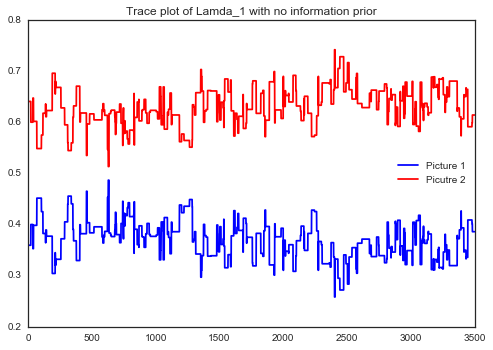

In [3]:
#Hyperparameters:
alpha = np.ones(2)
lambda_ = np.array([[1,1],[1,1]])

#Define priors:
rho = pm.CompletedDirichlet("rho", pm.Dirichlet("prho", theta=alpha))
theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=lambda_[i,:])) 
                      for i in range(2)])
z = pm.Container([pm.Multinomial('z_%i' % i,n=1, p = rho) for i in range(150)])

#Likelihood:
@pm.observed
def r(value = reports, z = z, theta = theta):
    like = 0
    for i in range(150):
        for j in range(3):
            like += pm.distributions.multinomial_like(reports[i][j],n=1,p=theta[np.argmax(z[i])])
    return like

model = pm.Model([rho,theta,z,r])
mc = pm.MCMC(model)

mc.sample(5000,burn = 1500)

plt.plot(range(len(mc.trace('theta_0')[:])),mc.trace('theta_0')[:][:,0][:,0],color='blue',label='Picture 1')
plt.plot(range(len(mc.trace('theta_0')[:])),mc.trace('theta_0')[:][:,0][:,1],color='red',label='Picutre 2')
plt.legend(loc=5)
plt.title('Trace plot of Lamda_1 with no information prior')
plt.show()

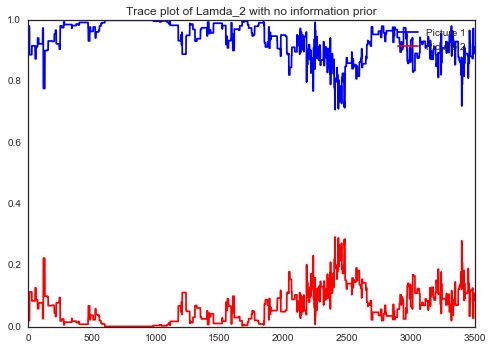

In [4]:
plt.plot(range(len(mc.trace('theta_1')[:])),mc.trace('theta_1')[:][:,0][:,0],color='blue',label='Picture 1')
plt.plot(range(len(mc.trace('theta_1')[:])),mc.trace('theta_1')[:][:,0][:,1],color='red',label='Picutre 2')
plt.legend()
plt.title('Trace plot of Lamda_2 with no information prior')
plt.show()

The confusion matrix we obtain is:

In [5]:
THETA_1 = np.array([[np.mean(mc.trace('theta_0')[:][:,0][:,0]),np.mean(mc.trace('theta_0')[:][:,0][:,1])],
                    [np.mean(mc.trace('theta_1')[:][:,0][:,0]),np.mean(mc.trace('theta_1')[:][:,0][:,1])]])
print THETA_1

[[ 0.36958451  0.63041549]
 [ 0.93718613  0.06281387]]


The distribution $\rho$ over the true labels is:

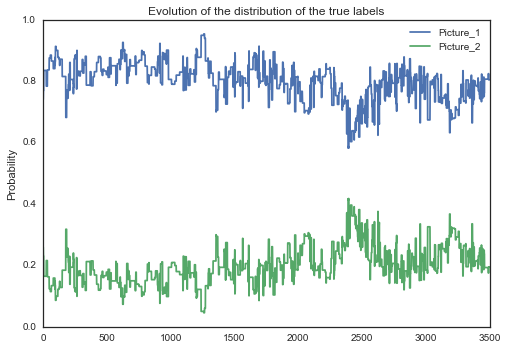

In [6]:
plt.plot(range(len(mc.trace('rho')[:])),mc.trace('rho')[:][:,0][:,0],label = 'Picture_1')
plt.plot(range(len(mc.trace('rho')[:])),mc.trace('rho')[:][:,0][:,1],label = 'Picture_2')
plt.legend()
plt.ylabel('Probability')
plt.title('Evolution of the distribution of the true labels')
plt.show()

The mean distribution is given by:

In [7]:
RHO_1 = np.array([np.mean(mc.trace('rho')[:][:,0][:,0]),np.mean(mc.trace('rho')[:][:,0][:,1])])
print RHO_1

[ 0.80057954  0.19942046]


##### $\lambda_1 = (a,b)$ and $\lambda_2 = (b,a)$ with $a>b$ Case

In [8]:
#Hyperparameters:
alpha = np.ones(2)
lambda_ = np.array([[3,1],[1,3]])

#Define priors:
rho2 = pm.CompletedDirichlet("rho", pm.Dirichlet("prho", theta=alpha))
theta2 = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=lambda_[i,:])) 
                      for i in range(2)])
z2 = pm.Container([pm.Multinomial('z_%i' % i,n=1, p = rho2) for i in range(150)])


#Likelihood:
@pm.observed
def r2(value = reports, z = z2, theta = theta2):
    like = 0
    for i in range(150):
        for j in range(3):
            like += pm.distributions.multinomial_like(reports[i][j],n=1,p=theta[np.argmax(z[i])])
    return like

model2 = pm.Model([rho2,theta2,z2,r2])
mc2 = pm.MCMC(model2)

mc2.sample(5000,burn = 1500)

 [-----------------100%-----------------] 5000 of 5000 complete in 703.4 sec

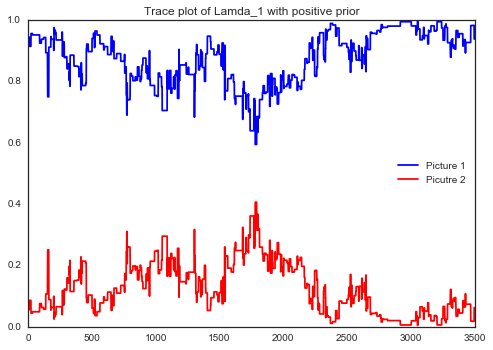

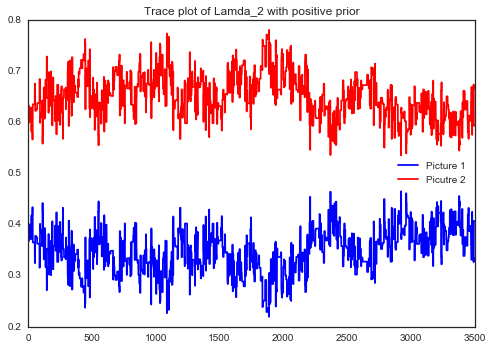

In [9]:
plt.plot(range(len(mc2.trace('theta_0')[:])),mc2.trace('theta_0')[:][:,0][:,0],color='blue',label='Picture 1')
plt.plot(range(len(mc2.trace('theta_0')[:])),mc2.trace('theta_0')[:][:,0][:,1],color='red',label='Picutre 2')
plt.legend(loc=5)
plt.title('Trace plot of Lamda_1 with positive prior')
plt.show()


plt.plot(range(len(mc2.trace('theta_1')[:])),mc2.trace('theta_1')[:][:,0][:,0],color='blue',label='Picture 1')
plt.plot(range(len(mc2.trace('theta_1')[:])),mc2.trace('theta_1')[:][:,0][:,1],color='red',label='Picutre 2')
plt.legend(loc=5)
plt.title('Trace plot of Lamda_2 with positive prior')
plt.show()

The confusion matrix is:

In [10]:
THETA_2 = np.array([[np.mean(mc2.trace('theta_0')[:][:,0][:,0]),np.mean(mc2.trace('theta_0')[:][:,0][:,1])],
                    [np.mean(mc2.trace('theta_1')[:][:,0][:,0]),np.mean(mc2.trace('theta_1')[:][:,0][:,1])]])
print THETA_2

[[ 0.87660597  0.12339403]
 [ 0.3489094   0.6510906 ]]


The distribution over the labels is:

In [11]:
RHO_2 = np.array([np.mean(mc2.trace('rho')[:][:,0][:,0]),np.mean(mc2.trace('rho')[:][:,0][:,1])])
print RHO_2

[ 0.25084198  0.74915802]


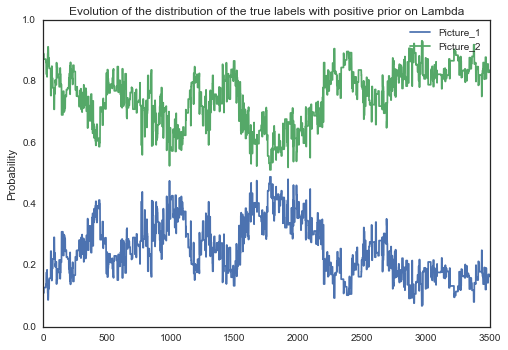

In [12]:
plt.plot(range(len(mc2.trace('rho')[:])),mc2.trace('rho')[:][:,0][:,0],label = 'Picture_1')
plt.plot(range(len(mc2.trace('rho')[:])),mc2.trace('rho')[:][:,0][:,1],label = 'Picture_2')
plt.legend()
plt.ylabel('Probability')
plt.title('Evolution of the distribution of the true labels with positive prior on Lambda')
plt.show()

##### $\lambda_1 = (a,b)$ and $\lambda_2 = (b,a)$ with $b>a$ Case

In [13]:
#Hyperparameters:
alpha = np.ones(2)
lambda_ = np.array([[1,2],[2,1]])

#Define priors:
rho3 = pm.CompletedDirichlet("rho", pm.Dirichlet("prho", theta=alpha))
theta3 = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=lambda_[i,:])) 
                      for i in range(2)])
z3 = pm.Container([pm.Multinomial('z_%i' % i,n=1, p = rho3) for i in range(150)])

#Likelihood:
@pm.observed
def r3(value = reports, z = z3, theta = theta3):
    like = 0
    for i in range(150):
        for j in range(3):
            like += pm.distributions.multinomial_like(reports[i][j],n=1,p=theta[np.argmax(z[i])])
    return like

model3 = pm.Model([rho3,theta3,z3,r3])
mc3 = pm.MCMC(model3)

mc3.sample(5000,burn = 1500)



 [-----------------100%-----------------] 5000 of 5000 complete in 678.4 sec

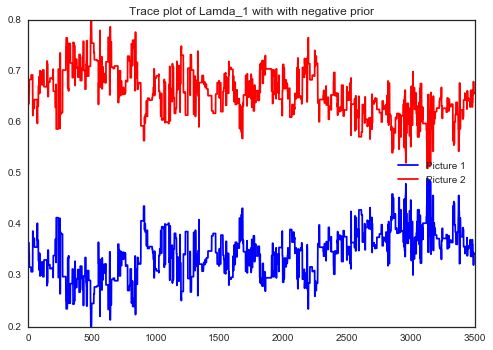

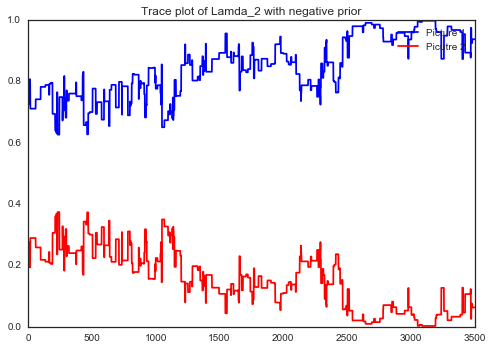

In [14]:
plt.plot(range(len(mc3.trace('theta_0')[:])),mc3.trace('theta_0')[:][:,0][:,0],color='blue',label='Picture 1')
plt.plot(range(len(mc3.trace('theta_0')[:])),mc3.trace('theta_0')[:][:,0][:,1],color='red',label='Picture 2')
plt.legend(loc=5)
plt.title('Trace plot of Lamda_1 with with negative prior')
plt.show()


plt.plot(range(len(mc3.trace('theta_1')[:])),mc3.trace('theta_1')[:][:,0][:,0],color='blue',label='Picture 1')
plt.plot(range(len(mc3.trace('theta_1')[:])),mc3.trace('theta_1')[:][:,0][:,1],color='red',label='Picutre 2')
plt.legend()
plt.title('Trace plot of Lamda_2 with negative prior')
plt.show()

The confusion matrix is given by:

In [15]:
THETA_3 = np.array([[np.mean(mc3.trace('theta_0')[:][:,0][:,0]),np.mean(mc3.trace('theta_0')[:][:,0][:,1])],
                    [np.mean(mc3.trace('theta_1')[:][:,0][:,0]),np.mean(mc3.trace('theta_1')[:][:,0][:,1])]])
print THETA_3

[[ 0.34318945  0.65681055]
 [ 0.84665839  0.15334161]]


The distribution over the labels is:

In [18]:
RHO_3 = np.array([np.mean(mc3.trace('rho')[:][:,0][:,0]),np.mean(mc3.trace('rho')[:][:,0][:,1])])
print RHO_3

[ 0.71725655  0.28274345]


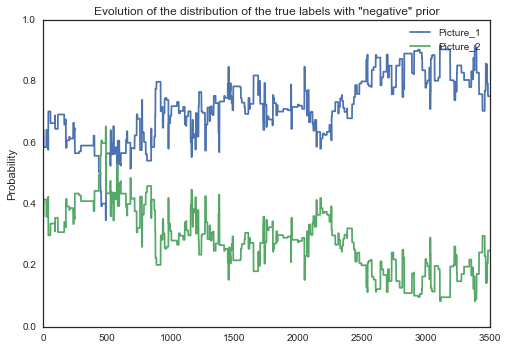

In [19]:
plt.plot(range(len(mc3.trace('rho')[:])),mc3.trace('rho')[:][:,0][:,0],label = 'Picture_1')
plt.plot(range(len(mc3.trace('rho')[:])),mc3.trace('rho')[:][:,0][:,1],label = 'Picture_2')
plt.legend()
plt.ylabel('Probability')
plt.title('Evolution of the distribution of the true labels with "negative" prior')
plt.show()